## Groups

After trying (and failing) to score higher than ~78% using numerous variations of stacked ensemble model, I decided to take a step back. Increasing complexity was obviously not increasing model accuracy. Perhaps if I better understood the problem and increased my domain knowledge, I would have a better chance of moving up the leaderboard.

I stumbled across an interesting notebook by Chris Deotte in which he creates a relatively high-scoring model using the Name feature alone: [Titanic using Name only](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818). Although parsing his R code was a bit of a challenge, Chris' commentary was extremely clear and logical. The basic premise is that we can infer family groups based on passenger last name, which is extracted from the Name field. Survival within these so-called "woman-child-groups" is almost always binary - either all members of the WCG die or all survive. Therefore, if a test case is presented for which we can determine family group status, we should predict survival based on the survival of the family group. Using this group-based strategy in conjunction with the baseline gender-based model in which all men die and all females survive results in an accuracy in the low 80%s. Having spent ages trying to perfect a more complicated stacked ensemble with no improvement, I decided to explore Chris' ideas and implement them in Python. Who knows, maybe I could find an enhancement or two!

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

SEED = 42
NFOLDS = 10

train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")

In [153]:
kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED)

In [154]:
test = test_.copy()
train = train_.copy()
test_train = pd.concat([test, train], sort=False)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Title**

In [155]:
def extract_title(x):
    return x.split(', ')[1].split(". ")[0].strip()

In [156]:
for dataset in [train, test, test_train]:
    dataset["Title"] = dataset["Name"].apply(extract_title)

**Last Name**

In [157]:
def extract_last_name(x):
    return x.split(",")[0].strip()

In [158]:
for dataset in [train, test, test_train]:
    dataset["LastName"] = dataset["Name"].apply(extract_last_name)

**Family Groups**

In general, family groups share a last name, a ticket number and fare amount. However, in some cases, the last digit of the ticket number varies within family groups (ex: Vander Planke family).

In [174]:
for dataset in [train, test, test_train]:
    dataset["FamilyGroup"] = dataset["LastName"] + " - " + dataset["Ticket"].str[:-1]
    # dataset["FamilyGroup"] = dataset["LastName"] + " - " + dataset["Ticket"].str[:-1] + " - " + dataset["Fare"].astype(str)

In [175]:
train.loc[train["LastName"] == "Andersson"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,Mr,Andersson,Andersson - 34708,7,False
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Miss,Andersson,Andersson - 310128,7,False
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,Andersson - 34708,7,False
146,147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S,Mr,Andersson,Andersson - 35004,1,True
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,Andersson - 34708,7,False
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,Andersson - 34708,7,False
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,Mrs,Andersson,Andersson - 34708,7,False
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,Andersson,Andersson - 34708,7,False
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,Master,Andersson,Andersson - 34708,7,False


In [176]:
train.loc[train["LastName"] == "Vander Planke"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0,NaN,S,Mrs,Vander Planke,Vander Planke - 34576,2,False
38,39,0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0,NaN,S,Miss,Vander Planke,Vander Planke - 34576,3,False
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0,NaN,S,Mr,Vander Planke,Vander Planke - 34576,3,False


In [177]:
train[train["FamilyGroup"] == "Andersson - 34708 - 31.275"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo


What is the distribution of ages of passengers with the title "Master"?

D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


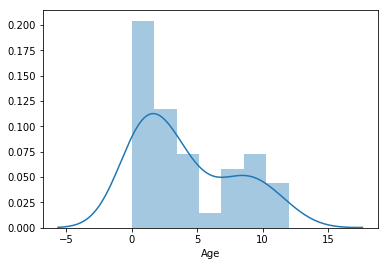

In [178]:
masters = train.loc[train["Title"] == "Master"]
masters["Age"].fillna(0, inplace=True)
sns.distplot(masters["Age"], bins=7)
plt.show()

The maximum age of passengers with the title "Master" is 12 (in the training dataset).

In [179]:
masters["Age"].describe()

count    40.000000
mean      4.116750
std       3.700119
min       0.000000
25%       1.000000
50%       3.000000
75%       7.250000
max      12.000000
Name: Age, dtype: float64

Are there any young men that do not have the title "Master"?

In [180]:
boys_without_master = train.loc[(train["Age"] < 18) & (train["Sex"] == "male") & (train["Title"] != "Master")]
boys_without_master

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo
86,87,0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.3750,NaN,S,Mr,Ford,Ford - W./C. 660,5,False
138,139,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,Mr,Osen,Osen - 753,1,True
163,164,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S,Mr,Calic,Calic - 31509,1,True
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,Mr,Sunderland,Sunderland - SOTON/OQ 39208,1,True
266,267,0,3,"Panula, Mr. Ernesti Arvid",male,16.0,4,1,3101295,39.6875,NaN,S,Mr,Panula,Panula - 310129,6,False
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,Mr,de Pelsmaeker,de Pelsmaeker - 34577,1,True
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",male,16.0,2,0,345764,18.0000,NaN,S,Mr,Vander Planke,Vander Planke - 34576,3,False
352,353,0,3,"Elias, Mr. Tannous",male,15.0,1,1,2695,7.2292,NaN,C,Mr,Elias,Elias - 269,3,False
433,434,0,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.1250,NaN,S,Mr,Kallio,Kallio - STON/O 2. 310127,1,True
500,501,0,3,"Calic, Mr. Petar",male,17.0,0,0,315086,8.6625,NaN,S,Mr,Calic,Calic - 31508,1,True


In [181]:
len(boys_without_master)

22

As we see, there are 22 young males on board who are under 18 years of age but do not have the title "Master". We might consider broadening our definition of "boy" to include these individuals.

**Family Size**

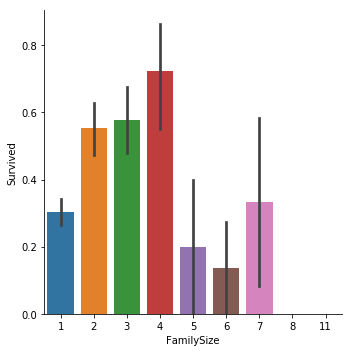

In [182]:
for dataset in [train, test, test_train]:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
sns.catplot(x="FamilySize", y="Survived", data=train, kind="bar")
plt.show()

**Solo Travelers**

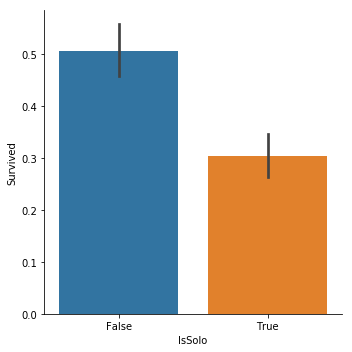

In [183]:
for dataset in [train, test, test_train]:
    dataset["IsSolo"] = dataset["FamilySize"] == 1

sns.catplot(x="IsSolo", y="Survived", data=train, kind="bar")
plt.show()

**Potential Families**

Families consist of 2 or more individuals (excluding men) that share the same FamilyGroup.

In [258]:
test_train_group_count = test_train.loc[(test_train["Sex"] != "male") | (test_train["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]].sort_index()
test_train_group_count.columns = ["Train + Test Count"]

train_group_count = pd.merge(train.loc[(train["Sex"] == "female") | (train["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]], 
                             train.loc[(train["Sex"] == "female") | (train["Title"] == "Master")].groupby("FamilyGroup").sum()[["Survived"]], how="inner", on="FamilyGroup")
train_group_count.columns = ["Train Count", "Survived"]

test_group_count = test.loc[(test["Sex"] == "female") | (test["Title"] == "Master")].groupby("FamilyGroup").count()[["PassengerId"]].sort_index()
test_group_count.columns = ["Test Count"]

In [261]:
groups = pd.merge(pd.merge(test_train_group_count, train_group_count, how="left", on="FamilyGroup"), test_group_count, how="left", on="FamilyGroup")
groups["Train Survival Rate"] = family_groups["Survived"] / family_groups["Train Count"]
groups = groups.reset_index()
groups.head(20)

,FamilyGroup,Train + Test Count,Train Count,Survived,Test Count,Train Survival Rate
0,Abbott - C.A. 267,2,1.0,1.0,1.0,1.000000
1,Abelseth - 34812,1,NaN,NaN,1.0,NaN
2,Abelson - P/PP 338,1,1.0,1.0,NaN,1.000000
3,Abrahim - 265,1,NaN,NaN,1.0,NaN
4,Ahlin - 754,1,1.0,0.0,NaN,0.000000
5,Aks - 39209,2,1.0,1.0,1.0,1.000000
6,Allen - 2416,1,1.0,1.0,NaN,1.000000
7,Allison - 11378,3,3.0,1.0,NaN,0.333333
8,Andersen-Jensen - 35004,1,1.0,1.0,NaN,1.000000
9,Andersson - 310128,1,1.0,1.0,NaN,1.000000


In [262]:
train[train["FamilyGroup"] == "Allison - 11378"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.55,C22 C26,S,Miss,Allison,Allison - 11378,4,False
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.55,C22 C26,S,Master,Allison,Allison - 11378,4,False
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.55,C22 C26,S,Mrs,Allison,Allison - 11378,4,False


In [263]:
familygroups = groups[groups["Train Count"] > 1][["FamilyGroup"]]
familygroups.head()

,FamilyGroup
7,Allison - 11378
10,Andersson - 34708
16,Asplund - 34707
23,Baclini - 266
26,Barbara - 269


In [264]:
families = groups[groups["FamilyGroup"].isin(familygroups["FamilyGroup"])]
families

,FamilyGroup,Train + Test Count,Train Count,Survived,Test Count,Train Survival Rate
7,Allison - 11378,3,3.0,1.0,NaN,0.333333
10,Andersson - 34708,6,6.0,0.0,NaN,0.000000
16,Asplund - 34707,6,4.0,3.0,2.0,0.750000
23,Baclini - 266,4,4.0,4.0,NaN,1.000000
26,Barbara - 269,2,2.0,0.0,NaN,0.000000
32,Becker - 23013,4,2.0,2.0,2.0,1.000000
42,Boulos - 267,3,2.0,0.0,1.0,0.000000
43,Bourke - 36484,2,2.0,0.0,NaN,0.000000
60,Caldwell - 24873,2,2.0,2.0,NaN,1.000000
68,Carter - 11376,3,3.0,3.0,NaN,1.000000


**Generate Submission**

In [265]:
test_men_ids = test.loc[(test["Sex"] == "male") & (test["Title"] != "Master")]
test_men_die_preds = pd.DataFrame({"PassengerId": test_men_ids["PassengerId"], "Survived": np.zeros(len(test_men_ids), dtype=int)})
test_men_die_preds.head()

,PassengerId,Survived
0,892,0
2,894,0
3,895,0
5,897,0
7,899,0


In [266]:
len(test_men_die_preds)

245

In [267]:
test_females_boys = test[~test["PassengerId"].isin(test_men["PassengerId"])].sort_values(by="FamilyGroup")
len(test_females_boys)

173

In [271]:
test_females_boys.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,LastName,FamilyGroup,FamilySize,IsSolo
392,1284,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.2500,NaN,S,Master,Abbott,Abbott - C.A. 267,3,False
345,1237,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.6500,NaN,S,Miss,Abelseth,Abelseth - 34812,1,True
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.00,0,0,2657,7.2292,NaN,C,Mrs,Abrahim,Abrahim - 265,1,True
307,1199,3,"Aks, Master. Philip Frank",male,0.83,0,1,392091,9.3500,NaN,S,Master,Aks,Aks - 39209,2,False
214,1106,3,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4,2,347091,7.7750,NaN,S,Miss,Andersson,Andersson - 34709,7,False


In [295]:
test_females_boys_rates = pd.merge(test_females_boys, groups, how="left", on="FamilyGroup")[["PassengerId", "FamilyGroup", "Sex", "Train + Test Count", "Train Count", "Survived", "Train Survival Rate"]]
test_females_boys_rates["Train Survival Rate"].fillna(-1, inplace=True)
test_females_boys_rates.head()

,PassengerId,FamilyGroup,Sex,Train + Test Count,Train Count,Survived,Train Survival Rate
0,1284,Abbott - C.A. 267,male,2,1.0,1.0,1.0
1,1237,Abelseth - 34812,female,1,NaN,NaN,-1.0
2,900,Abrahim - 265,female,1,NaN,NaN,-1.0
3,1199,Aks - 39209,male,2,1.0,1.0,1.0
4,1106,Andersson - 34709,female,1,NaN,NaN,-1.0


In [299]:
test_females_boys_rates["Prediction"] = np.zeros(len(test_females_boys_rates), dtype=int)
test_females_boys_rates.loc[(test_females_boys_rates["Sex"] == "female"), "Prediction"] = 1
test_females_boys_rates.loc[(test_females_boys_rates["Train Survival Rate"] >= 0.5), "Prediction"] = 1
test_females_boys_rates.loc[(test_females_boys_rates["Train Survival Rate"] < 0.5) & (test_females_boys_rates["Train Survival Rate"] != -1), "Prediction"] = 0
test_females_boys_rates

,PassengerId,FamilyGroup,Sex,Train + Test Count,Train Count,Survived,Train Survival Rate,Prediction
0,1284,Abbott - C.A. 267,male,2,1.0,1.0,1.00,1
1,1237,Abelseth - 34812,female,1,NaN,NaN,-1.00,1
2,900,Abrahim - 265,female,1,NaN,NaN,-1.00,1
3,1199,Aks - 39209,male,2,1.0,1.0,1.00,1
4,1106,Andersson - 34709,female,1,NaN,NaN,-1.00,1
5,1271,Asplund - 34707,male,6,4.0,3.0,0.75,1
6,1046,Asplund - 34707,male,6,4.0,3.0,0.75,1
7,911,Assaf Khalil - 269,female,1,NaN,NaN,-1.00,1
8,979,Badman - A/4 3141,female,1,NaN,NaN,-1.00,1
9,978,Barry - 33084,female,1,NaN,NaN,-1.00,1


In [304]:
test_females_boys_preds = test_females_boys_rates[["PassengerId", "Prediction"]]
test_females_boys_preds.columns = ["PassengerId", "Survived"]
output = pd.concat([test_men_die_preds, test_females_boys_preds]).sort_values(by="PassengerId")
output.to_csv("submissions/wcg-attempt1.csv", header=True, index=False)
output.head()

,PassengerId,Survived
0,892,0
166,893,1
2,894,0
3,895,0
80,896,1


In [305]:
len(test[test["Sex"] == "female"])

152

In [306]:
sum(output["Survived"])

154

In [308]:
t = pd.read_csv("submissions/stacked_model.csv")
np.sum(t["Survived"])

148

**Random Forest Predictions for Remaining Passengers**

In [23]:
def prepare_females_boys(df):
    men_ids = df.loc[(df["Sex"] == "male") & (df["Title"] != "Master")]["PassengerId"].values
    
    temp = df[~df["PassengerId"].isin(men_ids)]
    
    temp["Age"].fillna(temp["Age"].median(), inplace=True)

    one_hot_cols = ["Sex", "Embarked"]

    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
        
    return temp

In [24]:
females_boys = prepare_females_boys(train)

D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


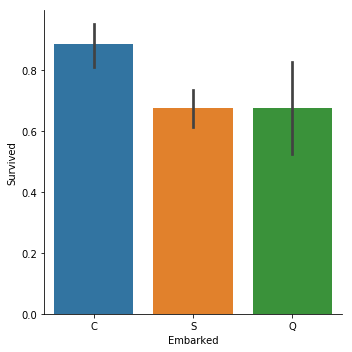

In [25]:
sns.catplot(x="Embarked", y="Survived", data=females_boys, kind="bar")
plt.show()

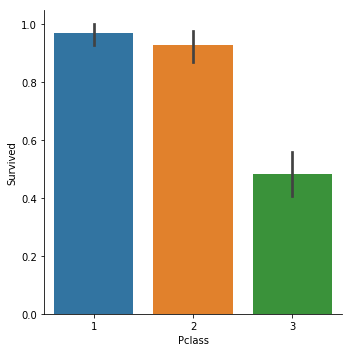

In [26]:
sns.catplot(x="Pclass", y="Survived", data=females_boys, kind="bar")
plt.show()

In [27]:
def prepare_X(df):
    passenger_ids = df["PassengerId"]
    df_cleaned = df.drop(columns=["PassengerId", "Name", "Sex", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked","LastName", "FamilyGroup", "Title"])
    return passenger_ids, df_cleaned

passenger_ids, X_train = prepare_X(females_boys)
y_train = X_train.pop("Survived")

In [28]:
rf = RandomForestClassifier(random_state=SEED)

rf_random_param = {'n_estimators': [200, 400, 600, 800],
               'max_features':['auto', 'sqrt'],
               'max_depth': [5, 10, 15, 20],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_random_param, n_iter=100, cv=kfold, random_state=SEED, n_jobs=-1, iid=False)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [29]:
rf_random.best_score_

0.8252707749766574

In [30]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}